In [ ]:

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
project_data = pd.read_csv("drive/My Drive/preprocessed_data.csv")

In [ ]:
project_data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
X = project_data
y = project_data["project_is_approved"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train) 
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)


(49041, 9)
(24155, 9)
(36052, 9)


In [ ]:

#https://www.kaggle.com/kredy10/simple-lstm-for-text-classification
from keras.preprocessing.text import Tokenizer
max_n_words = 800000
max_len = 700
token = Tokenizer(num_words=max_n_words)
token.fit_on_texts(X_train['essay'].tolist())
sequences_train = token.texts_to_sequences(X_train['essay'])
sequences_cv = token.texts_to_sequences(X_cv['essay'])
sequences_test = token.texts_to_sequences(X_test['essay'])

In [ ]:
len_n = len(token.word_index)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
train_pad = pad_sequences(sequences_train,maxlen=max_len,padding='post', truncating='post')
train_pad.shape

(49041, 700)

In [ ]:
cv_pad = pad_sequences(sequences_cv,maxlen=max_len,padding='post', truncating='post')
cv_pad.shape

(24155, 700)

In [ ]:
test_pad = pad_sequences(sequences_test,maxlen=max_len,padding='post', truncating='post')
test_pad.shape

(36052, 700)

In [ ]:
from keras.layers import Input
from keras import regularizers
import warnings 
embed_layer = Embedding(
  len_n + 1,
  250,
  input_length=max_len ,
  trainable=False
)

warnings.filterwarnings("ignore")
text_input = Input(shape=(max_len,),name="text_input1")
warnings.filterwarnings("ignore")
x = embed_layer(text_input)
warnings.filterwarnings("ignore")
x = LSTM(128,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x)
warnings.filterwarnings("ignore")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
from keras.layers import Flatten
flatten1 = Flatten()(x)

In [ ]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
def encode_data(X_train,X_cv,X_test,name1,name2):
  
  no_of_unique_word  = X_train.nunique()
  embed_size_word = int(min(np.ceil((no_of_unique_word)/2), 50 ))
  input_word = Input(shape=(1,),name=name1)
  embed_word = Embedding(no_of_unique_word + 1,embed_size_word + 1,name=name2,trainable=True)(input_word)
  flatten = Flatten()(embed_word)
  lb = preprocessing.LabelEncoder()
  lb.fit(X_train)
  X_train = X_train.map(lambda q: '<na>' if q not in lb.classes_ else q)
  X_cv = X_cv.map(lambda q: '<na>' if q not in lb.classes_ else q)
  X_test = X_test.map(lambda q: '<na>' if q not in lb.classes_ else q)
  lb.classes_ = np.append(lb.classes_, '<na>')
  encoder_train = lb.transform(X_train)
  encoder_cv = lb.transform(X_cv)
  encoder_test = lb.transform(X_test)
  return encoder_train , encoder_cv , encoder_test , flatten, input_word

In [ ]:
#school state
train_encode_ss , cv_encode_ss, test_encode_ss , flatten2,input_ss = encode_data(X_train['school_state'],X_cv['school_state'],X_test['school_state'],'school_state','emb.ss')

In [ ]:
#Project_grade_category
train_encode_pg , cv_encode_pg, test_encode_pg , flatten3,input_pg = encode_data(X_train['project_grade_category'],X_cv['project_grade_category'],X_test['project_grade_category'],'project_grade_category','emb.pg')

In [ ]:
#clean_categories
train_encode_ccat , cv_encode_ccat, test_encode_ccat , flatten4 ,input_ccat = encode_data(X_train['clean_categories'],X_cv['clean_categories'],X_test['clean_categories'],'clean_categories','emb.ccat')

In [ ]:
#clean_subcategories
train_encode_cscat , cv_encode_cscat, test_encode_cscat , flatten5 , input_cscat = encode_data(X_train['clean_subcategories'],X_cv['clean_subcategories'],X_test['clean_subcategories'],'clean_subcategories','emb.cscat')

In [ ]:
#teacher_prefix
train_encode_tp , cv_encode_tp, test_encode_tp , flatten6 ,input_tp = encode_data(X_train["teacher_prefix"],X_cv["teacher_prefix"],X_test["teacher_prefix"],'teacher_prefix','emb.tp')

In [ ]:
#teacher_number_of_previously_posted_projects.resourcesummary_contains_numerical_digits.price.quantity
train_num_nppp = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
train_num_price = X_train['price'].values.reshape(-1, 1)


cv_num_nppp = X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
cv_num_price = X_cv['price'].values.reshape(-1, 1)

test_num_nppp = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
test_num_price = X_test['price'].values.reshape(-1, 1)


In [ ]:
train_num = np.concatenate((train_num_nppp,train_num_price),axis=1)
cv_num = np.concatenate((cv_num_nppp,cv_num_price),axis=1)
test_num = np.concatenate((test_num_nppp,test_num_price),axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
train_num_s = Scaler.fit_transform(train_num)
cv_num_s = Scaler.transform(cv_num)
test_num_s = Scaler.transform(test_num)

In [ ]:
from keras.layers import Input , Dense,concatenate
from keras import regularizers
import warnings 
input_num = Input(shape=(2,),name="numerical_features")
input_num_dense = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(input_num)
warnings.filterwarnings("ignore")

In [ ]:
flatten = concatenate([flatten1,flatten2,flatten3,flatten4,flatten5,flatten6,input_num_dense])

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d
from keras.layers import Dropout
dense_x = Dense(256,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.0001))(flatten)
dense_x=Dropout(0.5)(dense_x)
dense_x1 = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.0001))(dense_x)
dense_x1=Dropout(0.5)(dense_x1)
dense_x2 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.0001))(dense_x1)

In [ ]:
from keras.layers import BatchNormalization
from keras.models import Model
x_nom = BatchNormalization()(dense_x2)
x_out  = Dense(2, activation='softmax', name='x_out')(x_nom)
model1 = Model(inputs=[text_input,input_ss,input_pg,input_ccat,input_cscat,input_tp,input_num],outputs=[x_out])
print(model1.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input1 (InputLayer)        (None, 700)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 700, 250)     10343500    text_input1[0][0]                
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 1)            0                                            
____________________________________________________________________________________________

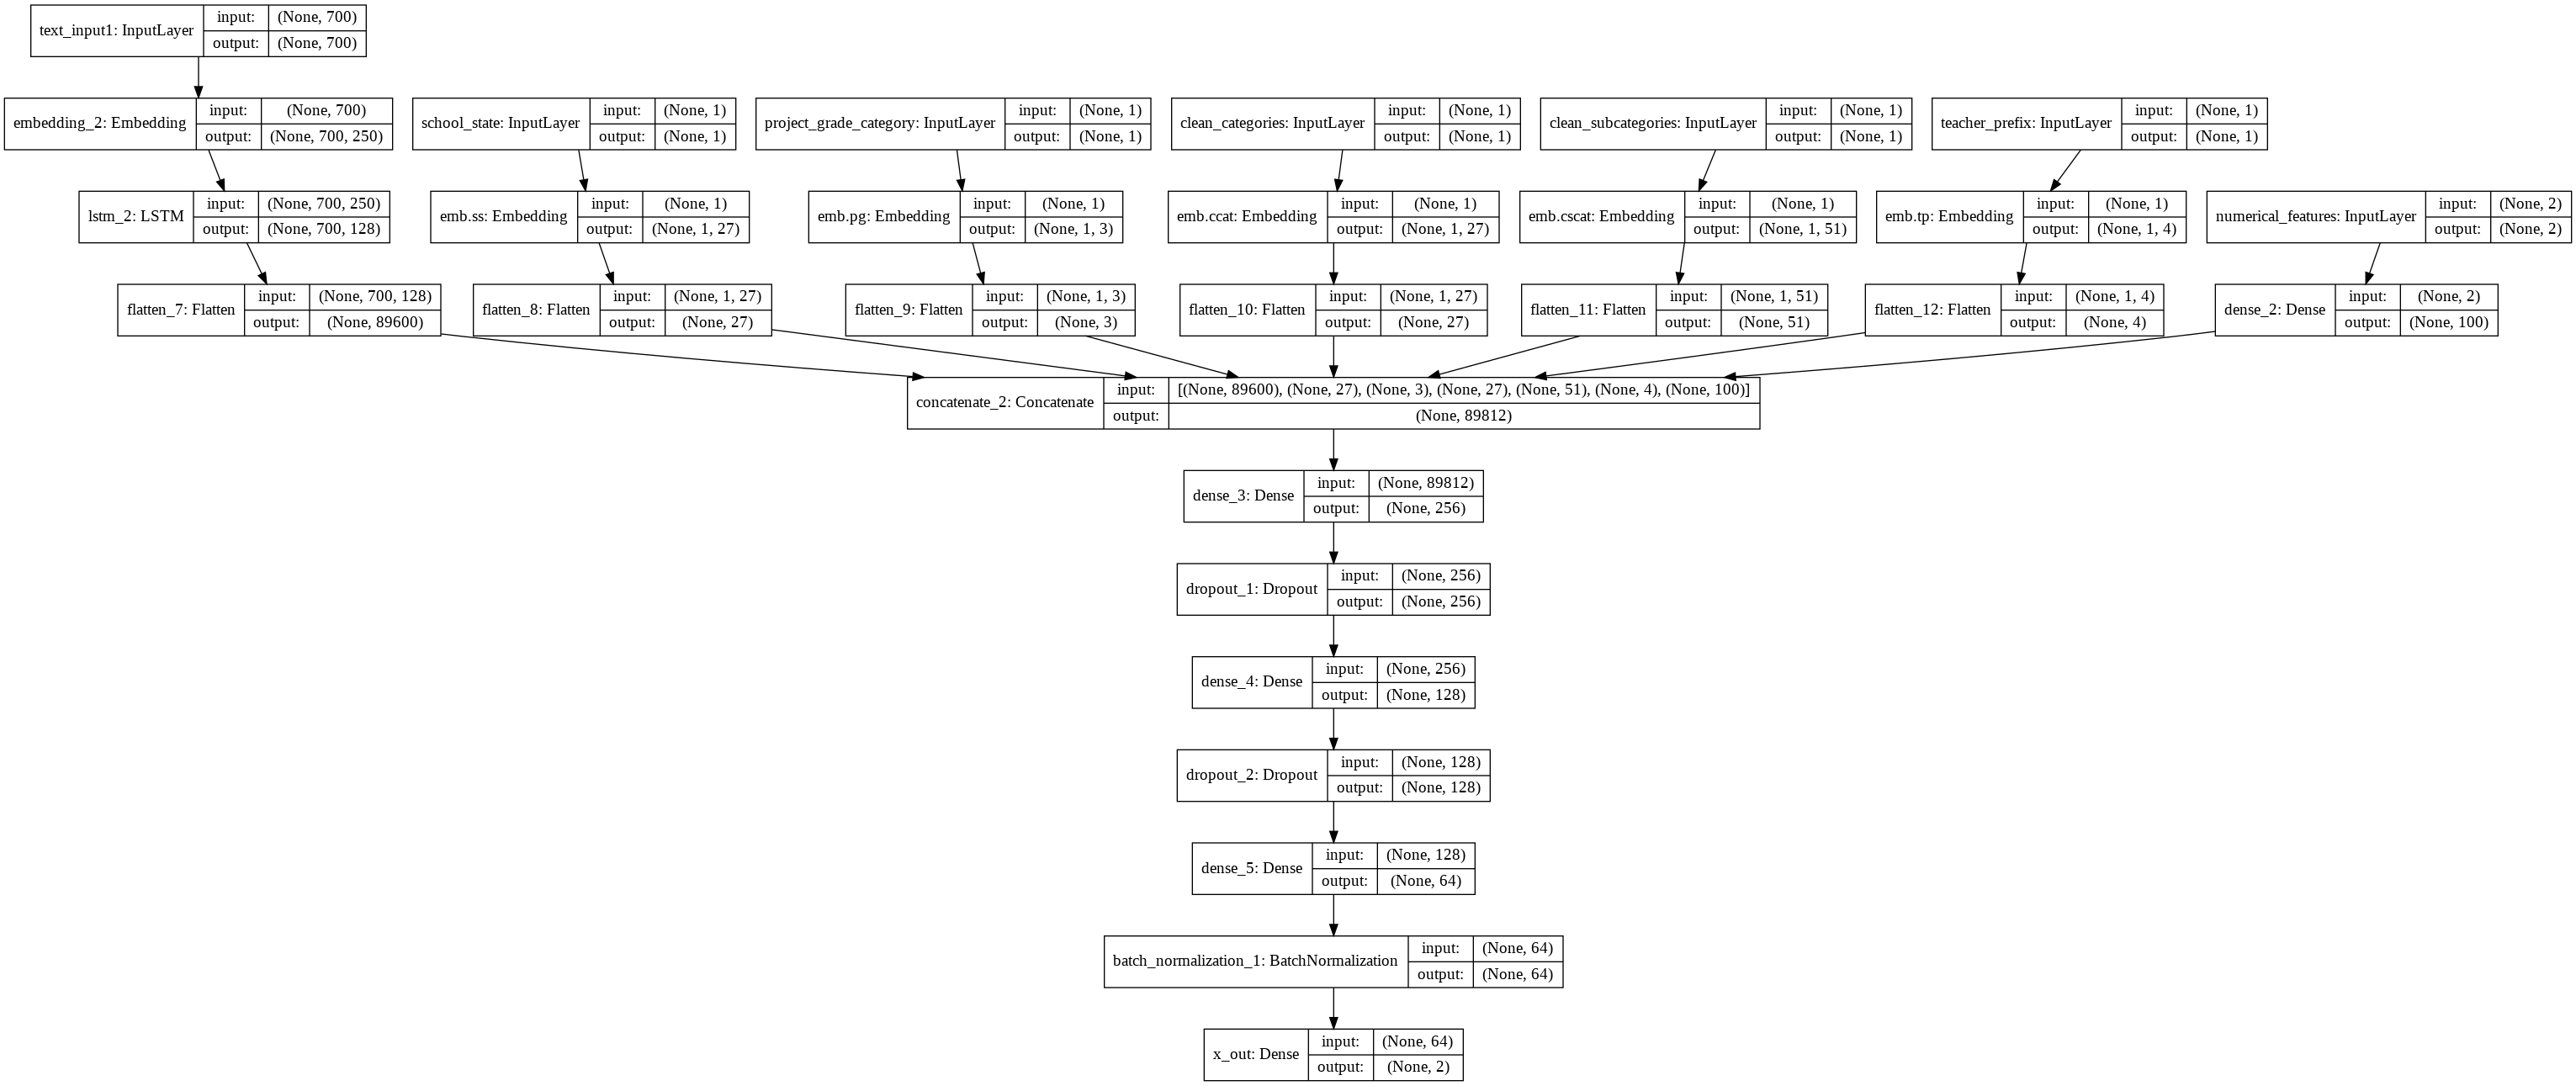

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/

from keras.utils import plot_model
from IPython.display import Image
plot_model(model1, show_shapes=True, show_layer_names=True, to_file='model1.png')
Image(retina=True, filename='model1.png')

In [ ]:
train_data = [train_pad,train_encode_ss,train_encode_pg,train_encode_ccat,train_encode_cscat,train_encode_tp,train_num_s]
             
test_data = [test_pad,test_encode_ss,test_encode_pg,test_encode_ccat,test_encode_cscat,test_encode_tp,test_num_s]

In [ ]:
model1.compile(optimizer = 'rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
warnings.filterwarnings("ignore")

In [ ]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [ ]:
from keras.callbacks import TensorBoard
tensorboard1 = TensorBoard(log_dir='./graphs1', histogram_freq=0, batch_size=512, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks1 = [tensorboard1]

In [ ]:
ml = model1.fit(train_data,Y_train,batch_size=512,epochs=5,validation_data=(test_data,Y_test),callbacks = callbacks1)
warnings.filterwarnings("ignore")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 49041 samples, validate on 36052 samples


Epoch 1/5
49041/49041 [==============================] - 1891s 39ms/step - loss: 1.4859 - acc: 0.7406 - val_loss: 1.0289 - val_acc: 0.8486
Epoch 2/5
49041/49041 [==============================] - 1855s 38ms/step - loss: 0.9005 - acc: 0.8470 - val_loss: 0.7859 - val_acc: 0.8486
Epoch 3/5
49041/49041 [==============================] - 1867s 38ms/step - loss: 0.7241 - acc: 0.8478 - val_loss: 0.6815 - val_acc: 0.8486
Epoch 4/5
49041/49041 [==============================] - 1869s 38ms/step - loss: 0.6289 - acc: 0.8482 - val_loss: 0.5926 - val_acc: 0.8486
Epoch 5/5
49041/49041 [==============================] - 1778s 36ms/step - loss: 0.5782 - acc: 0.8483 - val_loss: 0.5521 - val_acc: 0.8486


In [ ]:
!ls graphs1

events.out.tfevents.1568739839.fd88f87e92b4


In [ ]:
!ls graphs

events.out.tfevents.1568737778.fd88f87e92b4  plot
events.out.tfevents.1568737795.fd88f87e92b4


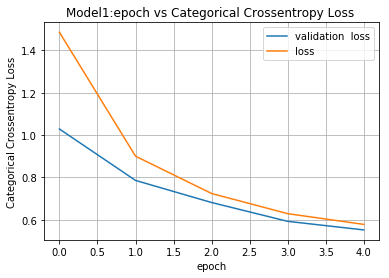

In [ ]:
#https://gist.github.com/tomrunia/1e1d383fb21841e8f144
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_tf_log(path,title):

    event_accm = EventAccumulator(path)
    event_accm.Reload()


    training_loss =   event_accm.Scalars('loss')
    validation_loss = event_accm.Scalars('val_loss')

    epoch = 5
    x = np.arange(epoch)
    y = np.zeros([epoch, 2])

    for j in range(epoch):
        y[j, 1] = validation_loss[j][2]
        y[j, 0] = training_loss[j][2]  
        
        
    plt.plot(x, y[:,1], label='validation  loss')
    plt.plot(x, y[:,0], label='loss')
    plt.title("Model1:epoch vs Categorical Crossentropy Loss ")
    plt.xlabel('epoch')
    plt.ylabel('Categorical Crossentropy Loss')
    plt.legend(loc='upper right', frameon=True)
    plt.grid()
    plt.show()


log_file = "./graphs1/events.out.tfevents.1568739839.fd88f87e92b4"
plot_tf_log(log_file)


#### Observation:
    From above plot we can see that train and test data loss are getting converged.

### Model 2 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(use_idf=True)
train_tfidf = tfidf.fit_transform(project_data['essay'])
get_idf = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))
train_tfidf_df = pd.DataFrame(list(get_idf.items()), columns=['Words', 'IDF'])
train_tfidf_df.describe()

,IDF
count,56345.000000
mean,10.552086
std,1.848827
min,1.007709
25%,9.893335
50%,11.502773
75%,11.908238
max,11.908238


#### from above data we can see that min IDF value is 1.007709 and maximum IDF value is 11.908238. So we will consider the word which IDF value is neither 1.007709 and nor 11.908238.
#### we will consider value beteen 25% and 75%.

Text(0.5, 1.0, 'Violin plot of idf')

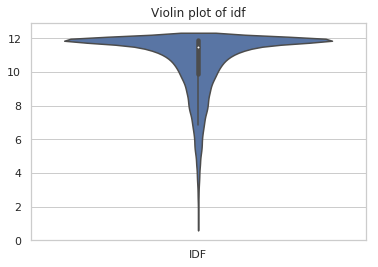

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
sns.violinplot(data=train_tfidf_df)
plt.title("Violin plot of idf")

In [ ]:
tfidf_data_train = train_tfidf_df[(train_tfidf_df['IDF']>9.893335) & (train_tfidf_df['IDF']<11.908238)]

In [ ]:
tfidf_data_train.shape

(41841, 2)

In [ ]:
train_tfidf_df.shape

(56345, 2)

In [ ]:
word = tfidf_data_train['Words'].tolist()

In [ ]:
token1 = Tokenizer()
token1.fit_on_texts(word)
sequences_train1 = token1.texts_to_sequences(X_train['essay'])
sequences_cv1 = token1.texts_to_sequences(X_cv['essay'])
sequences_test1 = token1.texts_to_sequences(X_test['essay'])

In [ ]:
train_pad1 = pad_sequences(sequences_train1,maxlen=max_len,padding='post', truncating='post')
train_pad1.shape

(49041, 700)

In [ ]:
cv_pad1 = pad_sequences(sequences_cv1,maxlen=max_len,padding='post', truncating='post')
cv_pad1.shape

(24155, 700)

In [ ]:
test_pad1 = pad_sequences(sequences_test1,maxlen=max_len,padding='post', truncating='post')
test_pad1.shape

(36052, 700)

In [ ]:
len_n = len(token1.word_index)

In [ ]:
embed_layer = Embedding(
  len_n + 1,
  250,
  input_length= max_len ,
  trainable=False
)

warnings.filterwarnings("ignore")
text_input1 = Input(shape=(max_len,),name="text_input2")
warnings.filterwarnings("ignore")
x = embed_layer(text_input1)
warnings.filterwarnings("ignore")
x = LSTM(128,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.0001),return_sequences=True)(x)
warnings.filterwarnings("ignore")

In [ ]:
from keras.layers import Flatten
flatten_txt = Flatten()(x)

In [ ]:
from keras.layers import Input , Dense,concatenate
flatten_m2 = concatenate([flatten_txt,flatten2,flatten3,flatten4,flatten5,flatten6,input_num_dense])

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d
from keras.layers import Dropout
dense_x = Dense(256,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.0001))(flatten_m2)
dense_x=Dropout(0.5)(dense_x)
dense_x1 = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.0001))(dense_x)
dense_x1=Dropout(0.5)(dense_x1)
dense_x2 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.0001))(dense_x1)

In [ ]:
from keras.layers import BatchNormalization
from keras.models import Model
x_nom = BatchNormalization()(dense_x2)
x_out  = Dense(2, activation='softmax', name='x_out')(x_nom)
model2 = Model(inputs=[text_input1,input_ss,input_pg,input_ccat,input_cscat,input_tp,input_num],outputs=[x_out])

In [ ]:
print(model2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input2 (InputLayer)        (None, 700)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 700, 250)     10460500    text_input2[0][0]                
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa (None, 1)            0                                            
____________________________________________________________________________________________

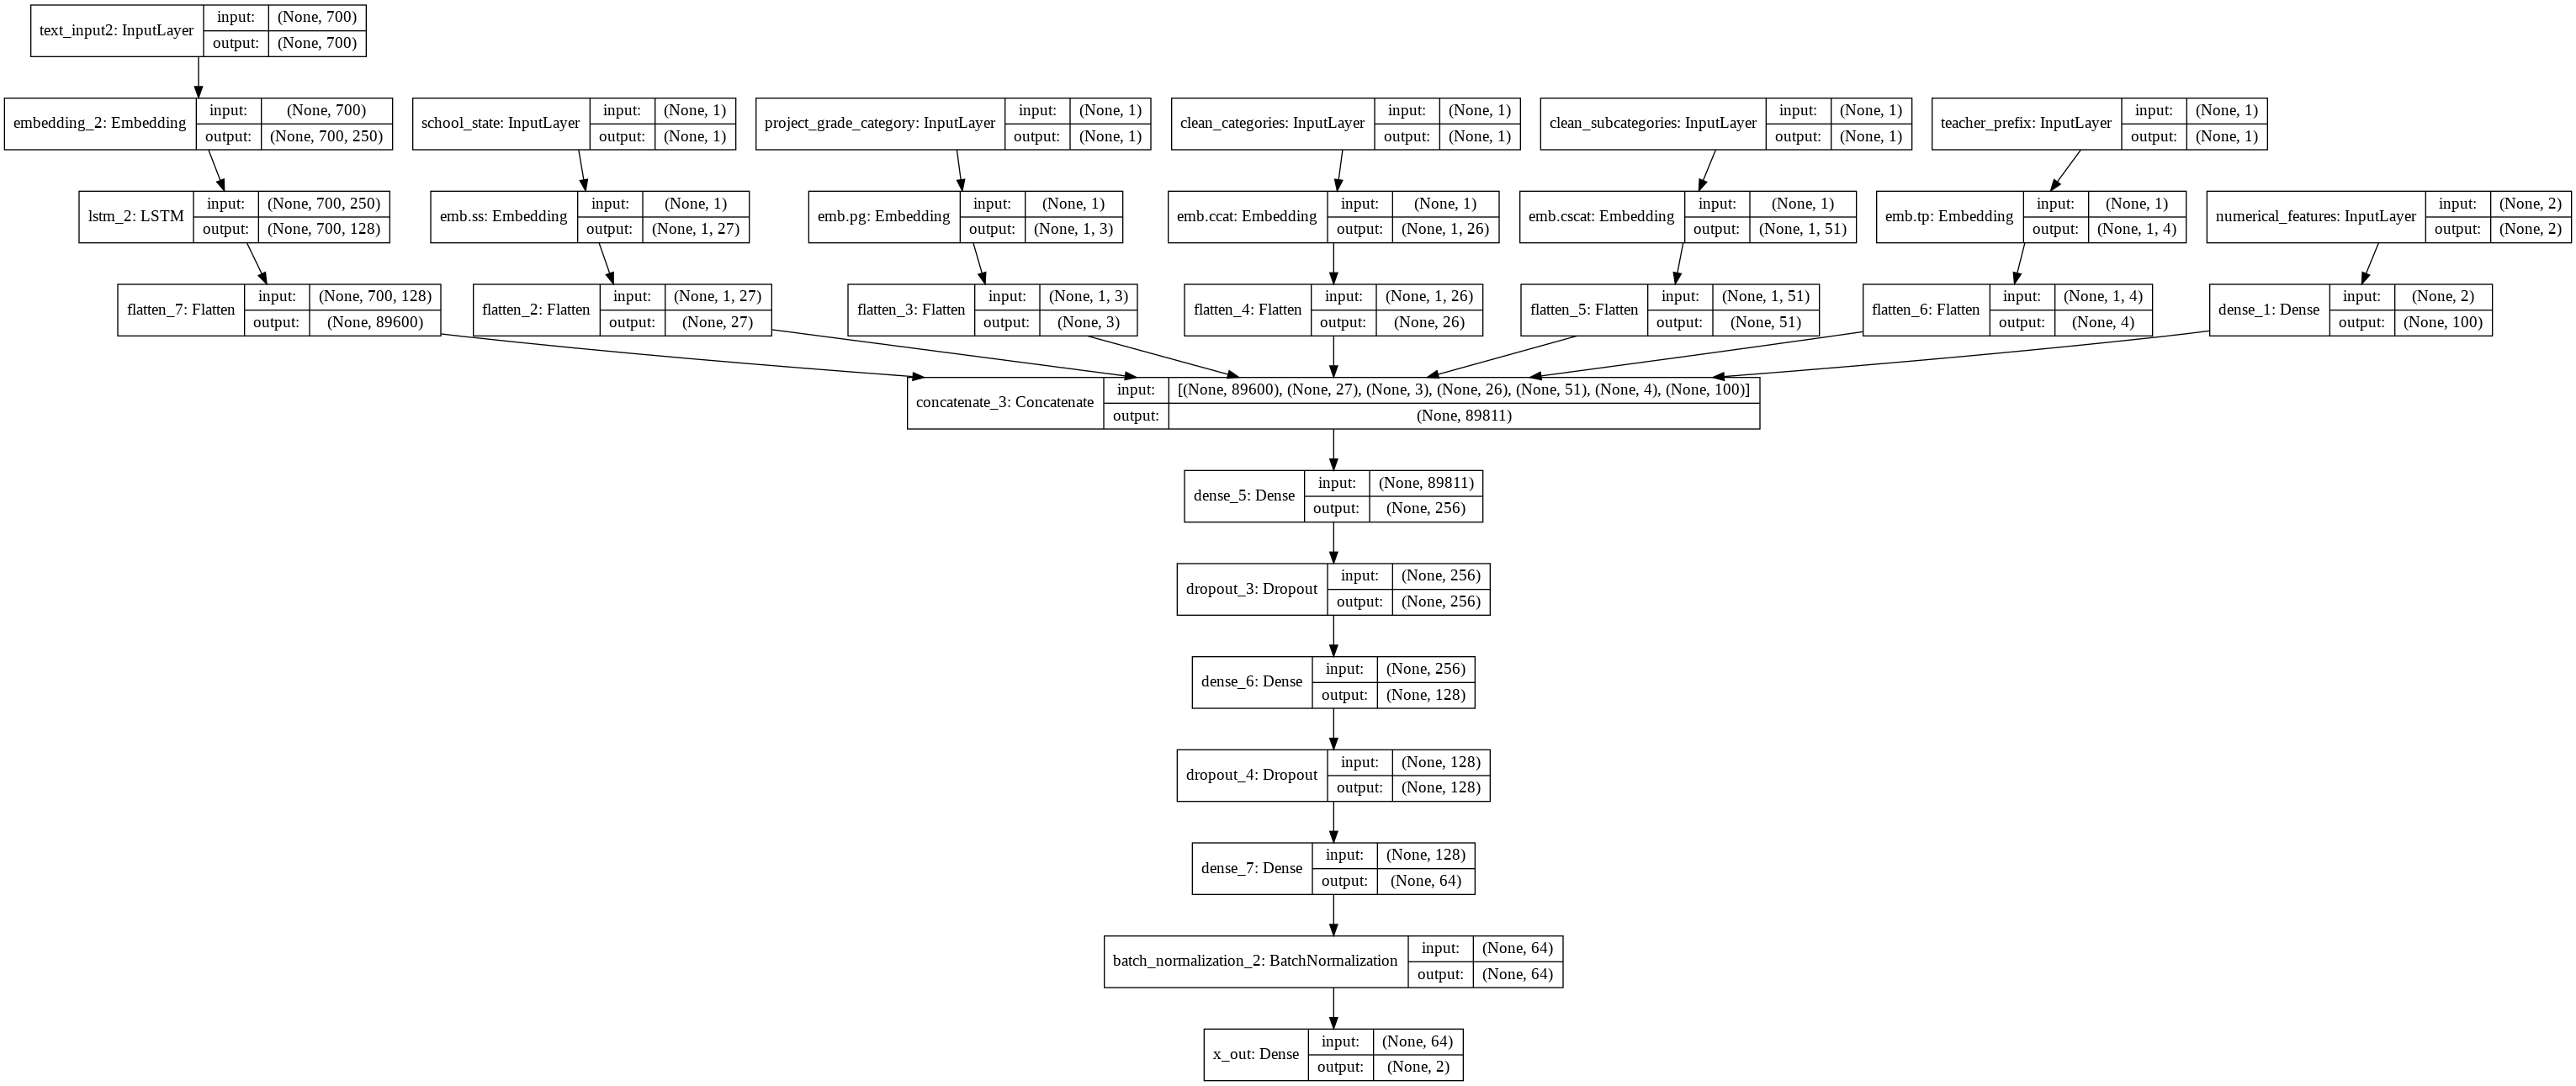

In [ ]:
from keras.utils import plot_model

from IPython.display import Image
plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model2.png')
Image(retina=True, filename='model2.png')

In [ ]:
train_data_m2 = [train_pad1,train_encode_ss,train_encode_pg,train_encode_ccat,train_encode_cscat,train_encode_tp,train_num_s]
             
test_data_m2 = [test_pad1,test_encode_ss,test_encode_pg,test_encode_ccat,test_encode_cscat,test_encode_tp,test_num_s]

In [ ]:
from keras.callbacks import TensorBoard
tensorboard_m2 = TensorBoard(log_dir='./graphs2', histogram_freq=0, batch_size=512, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_m2 = [tensorboard_m2]

In [ ]:
model2.compile(optimizer = 'rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
warnings.filterwarnings("ignore")

In [ ]:
m2 = model2.fit(train_data_m2,Y_train,batch_size=512,epochs=5,validation_data=(test_data_m2,Y_test),callbacks = callbacks_m2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 49041 samples, validate on 36052 samples


Epoch 1/5
49041/49041 [==============================] - 1053s 21ms/step - loss: 1.4690 - acc: 0.7588 - val_loss: 0.9978 - val_acc: 0.8486
Epoch 2/5
49041/49041 [==============================] - 1025s 21ms/step - loss: 0.8881 - acc: 0.8458 - val_loss: 0.7682 - val_acc: 0.8486
Epoch 3/5
49041/49041 [==============================] - 1003s 20ms/step - loss: 0.7047 - acc: 0.8479 - val_loss: 0.6384 - val_acc: 0.8486
Epoch 4/5
49041/49041 [==============================] - 1004s 20ms/step - loss: 0.6039 - acc: 0.8480 - val_loss: 0.5690 - val_acc: 0.8486
Epoch 5/5
49041/49041 [==============================] - 1004s 20ms/step - loss: 0.5552 - acc: 0.8479 - val_loss: 0.5323 - val_acc: 0.8486


In [ ]:
!ls graphs2

events.out.tfevents.1568772687.de371cb28e61


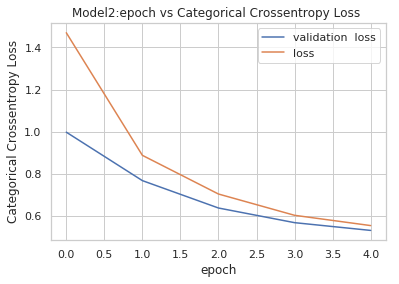

In [ ]:
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_tf_log(path):

    event_accm = EventAccumulator(path)
    event_accm.Reload()


    training_loss =   event_accm.Scalars('loss')
    validation_loss = event_accm.Scalars('val_loss')

    epoch = 5
    x = np.arange(epoch)
    y = np.zeros([epoch, 2])

    for i in range(epoch):
        y[i, 0] = training_loss[i][2] # value
        y[i, 1] = validation_loss[i][2]
        
    plt.plot(x, y[:,1], label='validation  loss')
    plt.plot(x, y[:,0], label='loss')
    plt.title("Model2:epoch vs Categorical Crossentropy Loss ")
    plt.xlabel('epoch')
    plt.ylabel('Categorical Crossentropy Loss')
    plt.legend(loc='upper right', frameon=True)
    plt.grid()
    plt.show()


log_file = "./graphs2/events.out.tfevents.1568772687.de371cb28e61"
plot_tf_log(log_file)


#### Observation:
    From above plot we can see that train and test data loss are getting converged.

### Model 3

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect_count = CountVectorizer()
train_ss1 = vect_count.fit_transform(X_train["school_state"])
cv_ss1 = vect_count.transform(X_cv["school_state"])
test_ss1 = vect_count.transform(X_test["school_state"])

In [ ]:
vect_count = CountVectorizer()
train_pg1 = vect_count.fit_transform(X_train["project_grade_category"])
cv_pg1 = vect_count.transform(X_cv["project_grade_category"])
test_pg1 = vect_count.transform(X_test["project_grade_category"])

In [ ]:
vect_count = CountVectorizer()
train_tp1 = vect_count.fit_transform(X_train["teacher_prefix"])
cv_tp1 = vect_count.transform(X_cv["teacher_prefix"])
test_tp1 = vect_count.transform(X_test["teacher_prefix"])

In [ ]:
vect_count = CountVectorizer()
train_ccat1 = vect_count.fit_transform(X_train["clean_categories"])
cv_ccat1 = vect_count.transform(X_cv["clean_categories"])
test_ccat1 = vect_count.transform(X_test["clean_categories"])

In [ ]:
vect_count = CountVectorizer()
train_cscat1 = vect_count.fit_transform(X_train["clean_subcategories"])
cv_cscat1 = vect_count.transform(X_cv["clean_subcategories"])
test_cscat1 = vect_count.transform(X_test["clean_subcategories"])

In [ ]:
vect_count = CountVectorizer()
train_cscat1 = vect_count.fit_transform(X_train["clean_subcategories"])
cv_cscat1 = vect_count.transform(X_cv["clean_subcategories"])
test_cscat1 = vect_count.transform(X_test["clean_subcategories"])

In [ ]:
from scipy.sparse import hstack
train_data_m2 = hstack([train_ss1,train_pg1,train_ccat1,train_cscat1,train_tp1,train_num_s]).todense()
cv_data_m2 = hstack([cv_ss1,cv_pg1,cv_ccat1,cv_cscat1,cv_tp1,cv_num_s]).todense()
test_data_m2 = hstack([test_ss1,test_pg1,test_ccat1,test_cscat1,test_tp1,test_num_s]).todense()

In [ ]:
train_data_m3 = np.expand_dims(train_data_m2,2)
cv_data_m3 = np.expand_dims(cv_data_m2,2)
test_data_m3 = np.expand_dims(test_data_m2,2)

In [ ]:
from keras.layers import Conv1D
inp_data =  Input(shape=(101, 1),name='all_data')
x_m3 = Conv1D(filters=64, kernel_size=3, activation='relu',kernel_initializer="he_normal")(inp_data)
x_m3 = Conv1D(filters=64, kernel_size=3, activation='relu',kernel_initializer="he_normal")(x_m3)
x_m3_f = Flatten()(x_m3)

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d
flatten_m3 = concatenate([flatten_txt,x_m3_f])
from keras.layers import Dropout
dense_x = Dense(256,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(flatten_m3)
dense_x=Dropout(0.5)(dense_x)
dense_x1 = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(dense_x)
dense_x1=Dropout(0.5)(dense_x1)
dense_x2 = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(dense_x1)

In [ ]:
x_out1  = Dense(2, activation='softmax', name='x_out')(dense_x2)
model3 = Model(inputs=[text_input1,inp_data],outputs=[x_out1])

In [ ]:
print(model3.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input2 (InputLayer)        (None, 700)          0                                            
__________________________________________________________________________________________________
all_data (InputLayer)           (None, 101, 1)       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 700, 250)     10460500    text_input2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 64)       256         all_data[0][0]                   
____________________________________________________________________________________________

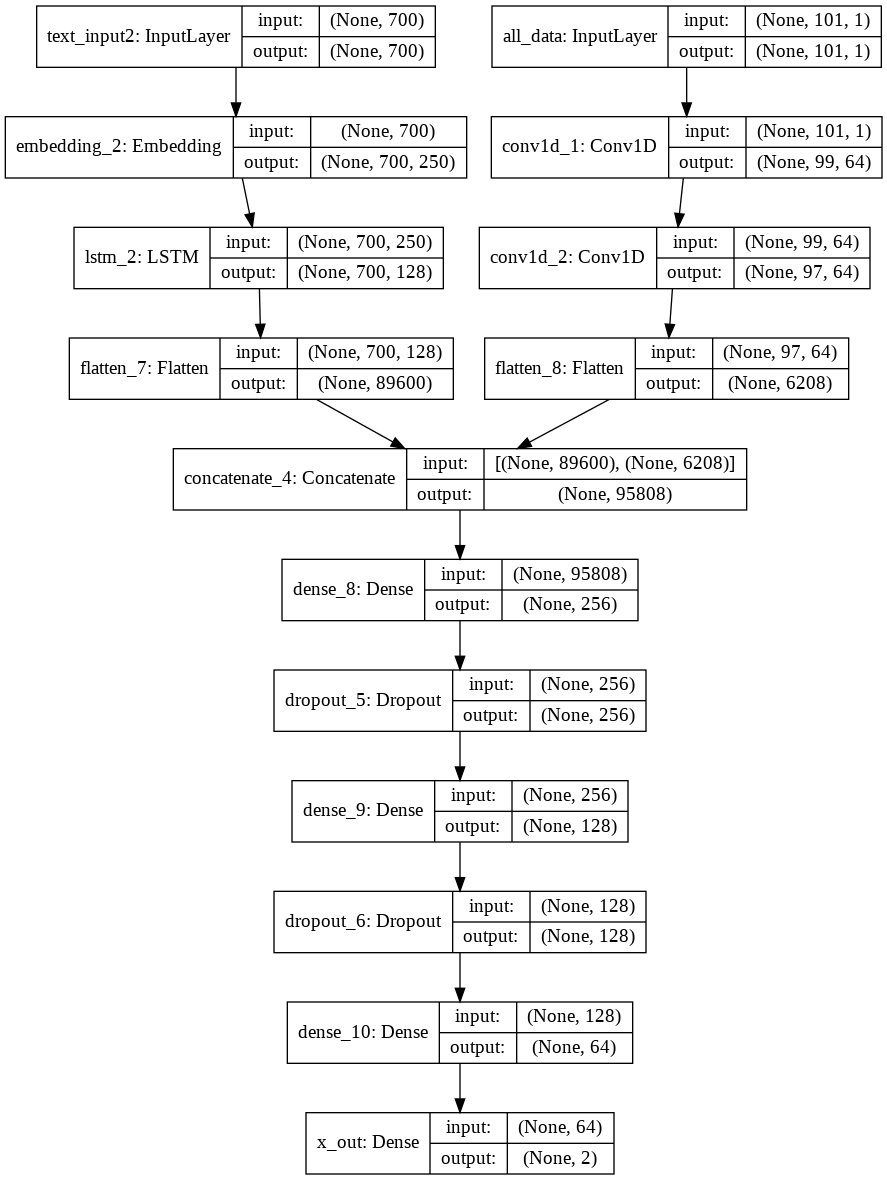

In [ ]:
from IPython.display import Image
from keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model3.png')
Image(retina=True, filename='model3.png')

In [ ]:

train_data_m3_f = [train_pad1,train_data_m3]
cv_data_m3_f    = [cv_pad1,cv_data_m3]
test_data_m3_f = [test_pad1,test_data_m3]

In [ ]:
from keras.callbacks import TensorBoard
tensorboard_m3 = TensorBoard(log_dir='./graphs3', histogram_freq=0, batch_size=512, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
callbacks_m3 = [tensorboard_m3]

In [ ]:
model3.compile(optimizer = 'rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
warnings.filterwarnings("ignore")

In [ ]:
m3 = model3.fit(train_data_m3_f,Y_train,batch_size=512,epochs=5,validation_data=(test_data_m3_f,Y_test),callbacks = callbacks_m3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 49041 samples, validate on 36052 samples


Epoch 1/5
49041/49041 [==============================] - 995s 20ms/step - loss: 1.4182 - acc: 0.8270 - val_loss: 0.9274 - val_acc: 0.8486
Epoch 2/5
49041/49041 [==============================] - 987s 20ms/step - loss: 0.7856 - acc: 0.8486 - val_loss: 0.6979 - val_acc: 0.8486
Epoch 3/5
49041/49041 [==============================] - 994s 20ms/step - loss: 0.6142 - acc: 0.8486 - val_loss: 0.6242 - val_acc: 0.8486
Epoch 4/5
49041/49041 [==============================] - 986s 20ms/step - loss: 0.5269 - acc: 0.8486 - val_loss: 0.4979 - val_acc: 0.8486
Epoch 5/5
49041/49041 [==============================] - 990s 20ms/step - loss: 0.4847 - acc: 0.8486 - val_loss: 0.4920 - val_acc: 0.8486


In [ ]:
!ls graphs3

events.out.tfevents.1568818786.f8e80050318f


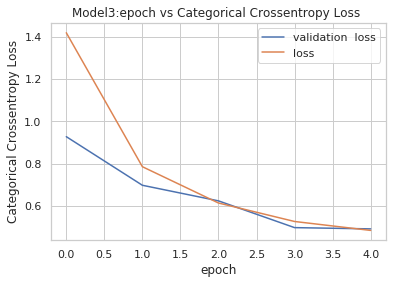

In [ ]:
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_tf_log(path):

    event_accm = EventAccumulator(path)
    event_accm.Reload()


    training_loss =   event_accm.Scalars('loss')
    validation_loss = event_accm.Scalars('val_loss')

    epoch = 5
    x = np.arange(epoch)
    y = np.zeros([epoch, 2])

    for i in range(epoch):
        y[i, 0] = training_loss[i][2]  
        y[i, 1] = validation_loss[i][2]
        
    plt.plot(x, y[:,1], label='validation  loss')
    plt.plot(x, y[:,0], label='loss')
    plt.title("Model3:epoch vs Categorical Crossentropy Loss ")
    plt.xlabel('epoch')
    plt.ylabel('Categorical Crossentropy Loss')
    plt.legend(loc='upper right', frameon=True)
    #plt.grid()
    plt.show()


log_file = "./graphs3/events.out.tfevents.1568818786.f8e80050318f"
plot_tf_log(log_file)


#### Observation:
    From above plot we can see that train and test data loss are getting converged.

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Total Params ", "Test Accuracy","Epoch vs loss graph"]

x.add_row(["Model 1",'33,593,458',0.8486,'Converge'])
x.add_row(["------------------------------------",'-------','-------', '-------'])
x.add_row(["Model 2",'33,710,458',0.8486,'Converge'])  
x.add_row(["------------------------------------",'-------', '-------', '--------'])
x.add_row(["Model 3",'35,235,542', 0.8486,'Converge'])
print(x)

+--------------------------------------+---------------+---------------+---------------------+
|                Model                 | Total Params  | Test Accuracy | Epoch vs loss graph |
+--------------------------------------+---------------+---------------+---------------------+
|               Model 1                |   33,593,458  |     0.8486    |       Converge      |
| ------------------------------------ |    -------    |    -------    |       -------       |
|               Model 2                |   33,710,458  |     0.8486    |       Converge      |
| ------------------------------------ |    -------    |    -------    |       --------      |
|               Model 3                |   35,235,542  |     0.8486    |       Converge      |
+--------------------------------------+---------------+---------------+---------------------+


### Conclusion

* Accuracy of all the Models are almost same. 
* From Categorical Crossentropy Loss vs Epoch, we can see that train and test data loss are getting converged.